# Минипроект №5.
   На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

   В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
   Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
   Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

Задания:
- Выберите метод, который предположительно подойдет в первом вопросе.
- Проверьте, являются ли дисперсии внутри групп гомогенными.
- Проведите тест на нормальность распределения.
- Сравните средние в представленных группах.
- Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
- Примите решение: какие картинки в итоге будем использовать?
- Выберите метод для второго теста.
- Визуализируйте распределение events для контрольной и тестовой групп. 
- Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
- Выберите формулу для модели, проведите тест.

Описание данных
- 5_task_1:
  - id – id клиента в эксперименте
  - group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
  - events – сколько блюд суммарно было заказано за период
- 5_task_2:
  - id – id клиента в эксперименте
  - segment – сегмент (high/low)
  - group – вид кнопки (control – старая версия, test – новая версия)
  - events – сколько блюд суммарно было заказано за период

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

### Задание №1.
Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

- A – прямоугольные 16:9
- B – квадратные
- C – прямоугольные 12:4

Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?
- сделаю вывод исключительно по графику
- t-test
- посчитаю хи-квадрат
- ANOVA

**Ответ:** ANOVA, так как хотим протестировать больше двух групп

### Задание №2.
Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [2]:
task_1 = pd.read_csv('C:/Users/79196/Projects/data/5_task_1.csv')
task_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [3]:
pg.anova(data=task_1, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


In [4]:
stats.levene(task_1.query('group == "A"').events, task_1.query('group == "B"').events, task_1.query('group == "C"').events)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

**Ответ:** p-value > 0.05, не отклоняем нулевую гипотезу

### Задание №3.
Также убедитесь, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата используйте параметр random_state=17 в методе sample.

In [5]:
sample_task_1_A = task_1[task_1['group'] == 'A']['events'].sample(1000, random_state=17)
sample_task_1_A

2688    48
233     51
9099    53
8652    29
2842    34
        ..
4536    33
7441    20
6372    42
1945    27
9493    28
Name: events, Length: 1000, dtype: int64

In [6]:
stats.shapiro(sample_task_1_A)

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [7]:
sample_task_1_B = task_1[task_1['group'] == 'B']['events'].sample(1000, random_state=17)
sample_task_1_B

12688    28
10233    38
19099    37
18652    47
12842    39
         ..
14536    21
17441    36
16372    47
11945    62
19493    59
Name: events, Length: 1000, dtype: int64

In [8]:
stats.shapiro(sample_task_1_B)

ShapiroResult(statistic=0.9980818629264832, pvalue=0.3186272084712982)

In [9]:
sample_task_1_C = task_1[task_1['group'] == 'C']['events'].sample(1000, random_state=17)
sample_task_1_C

22688    27
20233    34
29099    31
28652    41
22842    26
         ..
24536     2
27441    20
26372    34
21945    30
29493    36
Name: events, Length: 1000, dtype: int64

In [10]:
stats.shapiro(sample_task_1_C)

ShapiroResult(statistic=0.9981189966201782, pvalue=0.3360903561115265)

**Ответ:** все три группы (A, B, C) имеют нормальное распределение данных

### Задание №4.
Провести тест на трех группах.

In [11]:
stats.f_oneway(task_1.query('group == "A"').events, task_1.query('group == "B"').events, task_1.query('group == "C"').events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

- Для сравнения средних я использую ОДНОФАКТОРНЫЙ ДИСПЕРСИОННЫЙ АНАЛИЗ (F_ONEWAY)
- Значение статистики равно (окр. до целого) 2886
- р-уровень значимости составил 0
- Вывод : группы имеют статистически значимые различия между собой, выясним между какими именно группами есть эти различия.

In [12]:
print(pairwise_tukeyhsd(task_1.events, task_1.group))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034   0.0   7.7038  8.3642   True
     A      C  -2.1093   0.0  -2.4395 -1.7791   True
     B      C -10.1433   0.0 -10.4735 -9.8131   True
----------------------------------------------------


***Все три парные выборки различаются между собой***

### Задание №5.
Так какие картинки в итоге будем использовать?

**Ответ:** B - квадратные

### Задание №6.
Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Какой метод скорее всего пригодится в данном случае?
- однофакторный дисперсионный анализ
- t-test
- многофакторный дисперсионный анализ
- хи-квадрат

**Ответ:** многофакторный дисперсионный анализ

### Задание №7.
Посмотрим на данные. Для начала визуализируйте распределение events для контрольной и тестовой групп.

In [13]:
task_2 = pd.read_csv('C:/Users/79196/Projects/data/5_task_2.csv')
task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [14]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

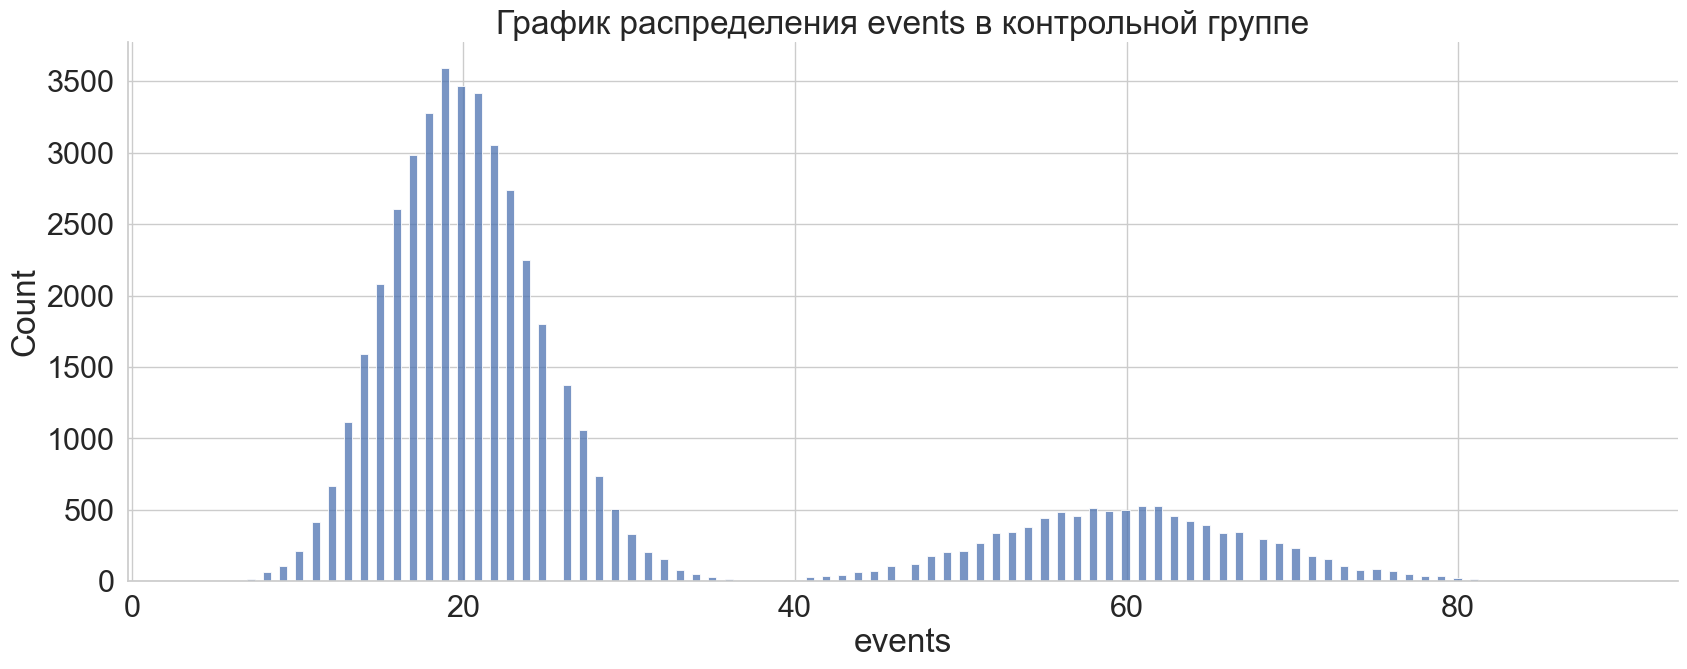

In [15]:
sns.histplot(task_2.query('group == "control"').events)
plt.title('График распределения events в контрольной группе')
sns.despine()

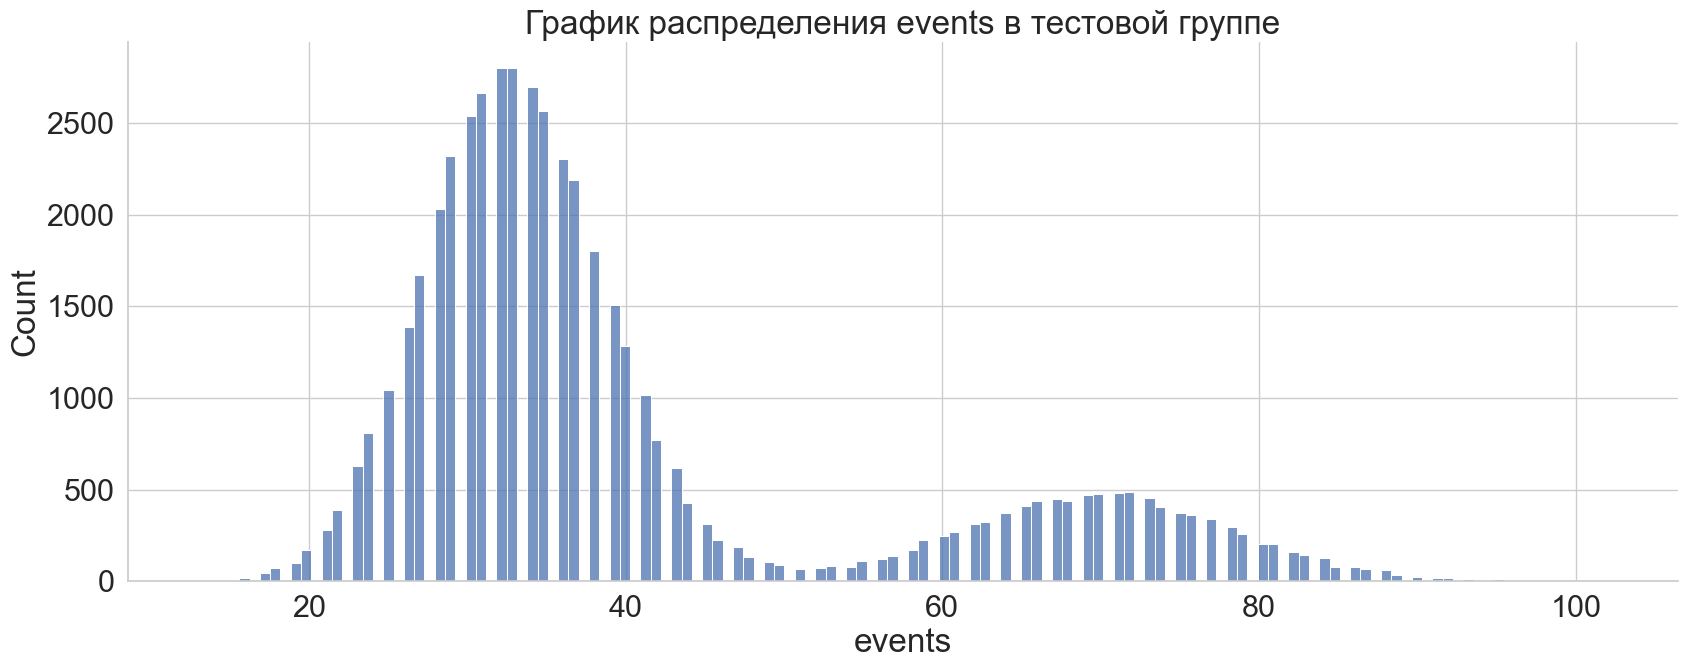

In [16]:
sns.histplot(task_2.query('group == "test"').events)
plt.title('График распределения events в тестовой группе')
sns.despine()

### Задание №8.
Посчитайте медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. В качестве ответа укажите стандартное отклонение для пользователей из сегмента high и контрольной группы, с точностью до 2 знаков после точки.

In [17]:
task_2.query('group == "test" & segment =="high"').events.median()

70.0

In [18]:
task_2.query('group == "test" & segment =="low"').events.median()

33.0

In [19]:
task_2.query('group == "control" & segment =="high"').events.median()

60.0

In [20]:
task_2.query('group == "control" & segment =="low"').events.median()

20.0

In [21]:
task_2.query('group == "test" & segment =="high"').events.std()

8.403974085398076

In [22]:
task_2.query('group == "test" & segment =="low"').events.std()

5.720845313076868

In [23]:
round(task_2.query('group == "control" & segment =="high"').events.std(), 2)

7.81

In [24]:
task_2.query('group == "control" & segment =="low"').events.std()

4.473575565622444

**Ответ:** стандартное отклонение для пользователей из сегмента high и контрольной группы = 7.81

### Задание №9.
Почти у цели – осталось выбрать формулу для модели. Напомним, что мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.

Какую формулу используете?

**Ответ:** events ~ segment + group + segment:group

In [25]:
formula = 'events ~ segment + group + segment:group'
model = ols(formula, task_2).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377485,0.000000e+00
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


### Задание №10.
Проведите тест, а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison.

Между какими группами были обнаружены статистически значимые различия? Выберите верные утверждения:
- Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 36
- Для обоих сегментов показатели статистически значимо _уменьшились_ по сравнению с контрольной группой
- Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой
- Различий совсем не оказалось :(
- Разница между control/high и test/high составила около 10
- Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13

In [26]:
task_2['combination'] = task_2.group + '/' + task_2.segment
task_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test/high
1,96723,test,high,71.0,test/high
2,68719,test,high,80.0,test/high
3,50399,test,high,80.0,test/high
4,95613,test,high,78.0,test/high


In [27]:
print(pairwise_tukeyhsd(task_2.events, task_2.combination)) 

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2   meandiff p-adj  lower    upper   reject
----------------------------------------------------------------
control/high control/low -39.9392   0.0 -40.1073 -39.7711   True
control/high   test/high   9.9677   0.0   9.7551  10.1803   True
control/high    test/low -26.9449   0.0  -27.113 -26.7768   True
 control/low   test/high  49.9069   0.0  49.7388   50.075   True
 control/low    test/low  12.9944   0.0   12.888  13.1007   True
   test/high    test/low -36.9126   0.0 -37.0807 -36.7445   True
----------------------------------------------------------------


**Ответ:** 
- Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой
- Разница между control/high и test/high составила около 10
- Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13

### Задание №11.
Визуализируйте результаты теста.

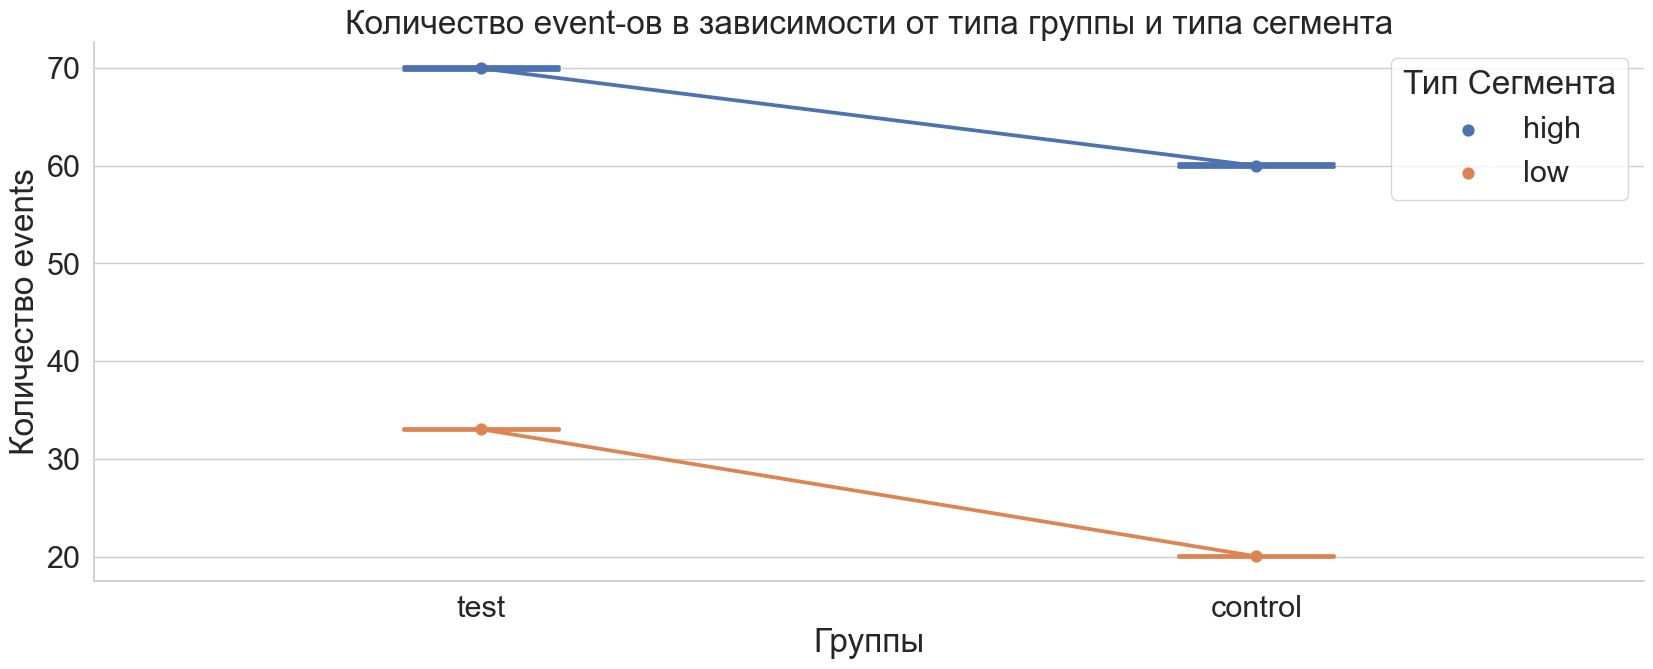

In [28]:
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = task_2, capsize = .2)
plt.title('Количество event-ов в зависимости от типа группы и типа сегмента')
plt.xlabel('Группы')
plt.ylabel('Количество events')
plt.legend(title = 'Тип Сегмента')
sns.despine()